# Figures 9-11. Glass system breakdown of GlassNet prediction accuracy

Make sure environment is using `glasspy 0.5.0`, currently available in the `dev` branch of [`glasspy`](https://github.com/drcassar/glasspy).

In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo
from glasspy.chemistry.convert import to_array, wt_to_mol

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np

from utils import get_gs, get_gfa, get_eta_tl, make_ternaries

In [2]:
gs_cols = ['K_W_Tc', 'gamma_Tc', 'H_prime_Tc', 'Jezica']
gs_titles = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', r'$H^{\prime}(T_{c})$', '$JEZ$']

# Data

## Load GlassNet training and test data

In [3]:
glassnet_stnn = GlassNet()
glassnet_test_df = glassnet_stnn.get_test_dataset()
glassnet_train_df = glassnet_stnn.get_training_dataset()

In [4]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [5]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [6]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [7]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total = pd.concat( (X_glassnet_feats_train, X_glassnet_feats_test) )

In [8]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

In [9]:
y_glassnet_train['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_train.Tliq,
                                                                          composition = X_glassnet_train)

In [10]:
y_glassnet_test['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_test.Tliq,
                                                                          composition = X_glassnet_test)

In [11]:
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

# Compute GS and GFA

In [12]:
gs_glassnet_train = get_gs(y_glassnet_train, jez=True)
gs_glassnet_test = get_gs(y_glassnet_test, jez=True)

In [13]:
gfa_glassnet_train = get_gfa(y_glassnet_train)['GFA'].replace([np.inf, -np.inf], np.nan).dropna()
gfa_glassnet_test = get_gfa(y_glassnet_test)['GFA'].replace([np.inf, -np.inf], np.nan).dropna()

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test ) )
gfa_glassnet_total = pd.concat( (gfa_glassnet_train, gfa_glassnet_test) )

# Generate ternary composition grids

In [16]:
NaFePO_df= pd.read_csv('../data/Na2O_Fe2O3_P2O5_grid.csv')
NaFePO_at_perc_df = NaFePO_df[ ['Na2O at %', 'Fe2O3 at %', 'P2O5 at %'] ] / 100
NaFePO_at_perc_df.columns = NaFePO_at_perc_df.columns.str.strip(' at %')
NaFePO_at_chem_arr = to_array(NaFePO_at_perc_df)
NaFePO_at_chem_arr

ChemArray
['Na2O', 'Fe2O3', 'P2O5']
[[0.    0.    1.   ]
 [0.    0.025 0.975]
 [0.    0.05  0.95 ]
 ...
 [0.975 0.    0.025]
 [0.975 0.025 0.   ]
 [1.    0.    0.   ]]


In [17]:
NaBSiO_df = NaFePO_df[ ['Na2O at %', 'Fe2O3 at %', 'P2O5 at %'] ] / 100
NaBSiO_df.rename( columns = { 'Fe2O3 at %': 'B2O3 at %', 'P2O5 at %': 'SiO2 at %' }, inplace=True )

In [18]:
NaBSiO_at_perc_df = NaBSiO_df
NaBSiO_at_perc_df.columns = NaBSiO_at_perc_df.columns.str.strip(' at %')
NaBSiO_at_chem_arr = to_array(NaBSiO_at_perc_df)
NaBSiO_at_chem_arr

ChemArray
['Na2O', 'B2O3', 'SiO2']
[[0.    0.    1.   ]
 [0.    0.025 0.975]
 [0.    0.05  0.95 ]
 ...
 [0.975 0.    0.025]
 [0.975 0.025 0.   ]
 [1.    0.    0.   ]]


In [19]:
X_glassnet_feats_NaFePO, feats = glassnet_stnn.featurizer(NaFePO_at_chem_arr, return_cols = True)
X_glassnet_feats_NaFePO = pd.DataFrame(X_glassnet_feats_NaFePO, columns = feats)
X_glassnet_feats_NaBSiO, feats = glassnet_stnn.featurizer(NaBSiO_at_chem_arr, return_cols = True)
X_glassnet_feats_NaBSiO = pd.DataFrame(X_glassnet_feats_NaBSiO, columns = feats)

# Indirect RF

### NaFePO

In [20]:
# train RF on total datasets and predict on ternary
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaFePO_df), len(cols) ) )
for i,col in enumerate(cols):
    this_y_train = y_glassnet_total[col].dropna()
    this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
    rf.fit( this_X_train, this_y_train )

    y_preds[:,i] = rf.predict(X_glassnet_feats_NaFePO)

y_preds_df_NaFePO = pd.DataFrame( y_preds, columns = cols )
y_preds_df_NaFePO['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df_NaFePO.Tliq,
                                                                          composition = NaFePO_at_chem_arr)
gs_pred_NaFePO = get_gs( y_preds_df_NaFePO, jez=True )
gfa_pred_NaFePO = get_gfa( y_preds_df_NaFePO )
y_preds_df_NaFePO = pd.concat( (NaFePO_df, y_preds_df_NaFePO), axis=1 )
y_preds_df_NaFePO.to_csv('GS_NaFePO_rf_indirect.csv', index=False)

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### NaBSiO

In [21]:
# train RF on total datasets and predict on ternary
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaBSiO_df), len(cols) ) )
for i,col in enumerate(cols):
    this_y_train = y_glassnet_total[col].dropna()
    this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
    rf.fit( this_X_train, this_y_train )

    y_preds[:,i] = rf.predict(X_glassnet_feats_NaBSiO)

y_preds_df_NaBSiO = pd.DataFrame( y_preds, columns = cols )
y_preds_df_NaBSiO['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df_NaBSiO.Tliq,
                                                                          composition = NaBSiO_at_chem_arr)
gs_pred_NaBSiO = get_gs( y_preds_df_NaBSiO, jez=True )
gfa_pred_NaBSiO = get_gfa( y_preds_df_NaBSiO )
y_preds_df_NaBSiO = pd.concat( (NaBSiO_df, y_preds_df_NaBSiO), axis=1 )
y_preds_df_NaBSiO.to_csv('GS_NaBSiO_rf_indirect.csv', index=False)

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Direct RF

### NaFePO

In [22]:
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaFePO_df), len(gs_cols)-1 ) )
for i,col in enumerate(gs_cols):
    if col != 'Jezica':
        this_y_train = gs_glassnet_total[col].dropna()
        this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
        rf.fit( this_X_train, this_y_train )

        y_preds[:,i] = rf.predict(X_glassnet_feats_NaFePO)

y_preds_df_NaFePO = pd.DataFrame( y_preds, columns = [col for col in gs_cols if col != 'Jezica'] )
y_preds_df_NaFePO = pd.concat( (NaFePO_df, y_preds_df_NaFePO), axis=1 )
y_preds_df_NaFePO.to_csv('GS_NaFePO_rf_direct.csv', index=False)

### NaBSiO

In [23]:
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaBSiO_df), len(gs_cols)-1 ) )
for i,col in enumerate(gs_cols):
    if col != 'Jezica':
        this_y_train = gs_glassnet_total[col].dropna()
        this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
        rf.fit( this_X_train, this_y_train )

        y_preds[:,i] = rf.predict(X_glassnet_feats_NaBSiO)

y_preds_df_NaBSiO = pd.DataFrame( y_preds, columns = [col for col in gs_cols if col != 'Jezica'] )
y_preds_df_NaBSiO = pd.concat( (NaBSiO_df, y_preds_df_NaBSiO), axis=1 )
y_preds_df_NaBSiO.to_csv('GS_NaBSiO_rf_direct.csv', index=False)

# GlassNet Predictions

### NaFePO

In [24]:
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
y_preds = glassnet_stnn.predict( NaFePO_at_chem_arr ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_preds_df_NaFePO = pd.DataFrame( y_preds, columns = cols )
y_preds_df_NaFePO['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df_NaFePO.Tliq,
                                                                          composition = NaFePO_at_chem_arr)
gs_preds_NaFePO = get_gs( y_preds_df_NaFePO, jez=True )
gfa_pred_NaFePO = get_gfa( y_preds_df_NaFePO )
y_preds_df_NaFePO = pd.concat( (NaFePO_df, y_preds_df_NaFePO), axis=1 )
y_preds_df_NaFePO.to_csv('GS_NaFePO_glassnet_indirect.csv', index=False)

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### NaBSiO

In [25]:
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
y_preds = glassnet_stnn.predict( NaBSiO_at_chem_arr ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_preds_df_NaBSiO = pd.DataFrame( y_preds, columns = cols )
y_preds_df_NaBSiO['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df_NaBSiO.Tliq,
                                                                          composition = NaBSiO_at_chem_arr)
gs_preds_NaBSiO = get_gs( y_preds_df_NaBSiO, jez=True )
gfa_pred_NaBSiO = get_gfa( y_preds_df_NaBSiO )
y_preds_df_NaBSiO = pd.concat( (NaBSiO_df, y_preds_df_NaBSiO), axis=1 )
y_preds_df_NaBSiO.to_csv('GS_NaBSiO_glassnet_indirect.csv', index=False)

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Make ternaries

$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaFePO_rf_direct.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaFePO_rf_direct.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaFePO_rf_direct.png
$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaFePO_rf_indirect.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaFePO_rf_indirect.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaFePO_rf_indirect.png
$JEZ$
figures/Jezica_GS_NaFePO_rf_indirect.png
$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaFePO_glassnet_indirect.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaFePO_glassnet_indirect.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaFePO_glassnet_indirect.png
$JEZ$
figures/Jezica_GS_NaFePO_glassnet_indirect.png


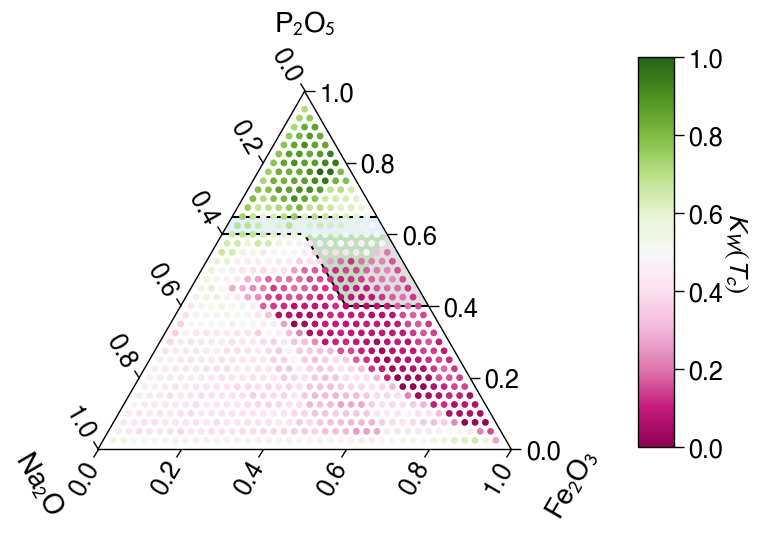

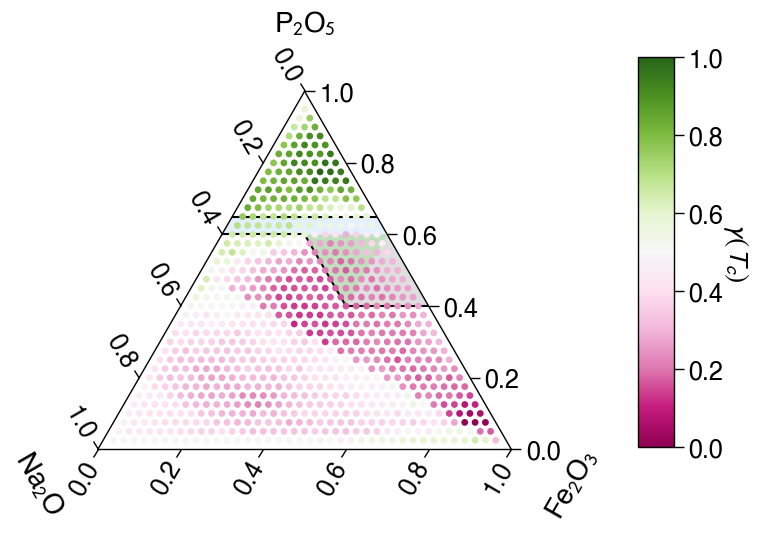

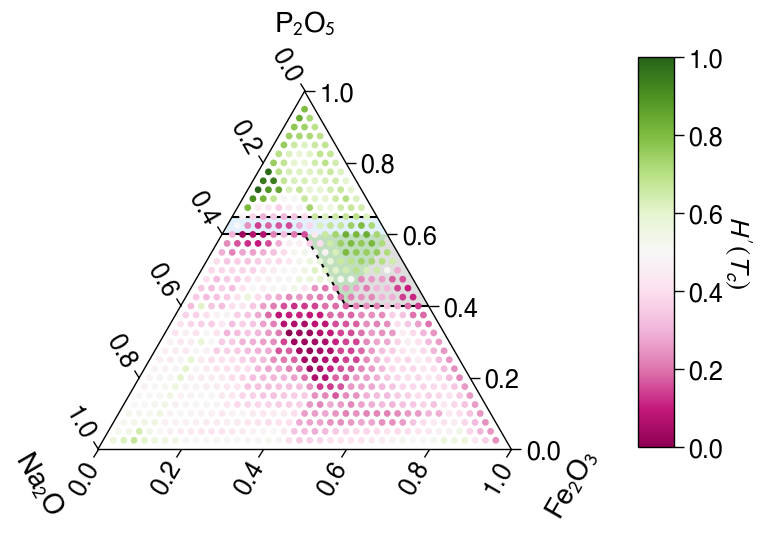

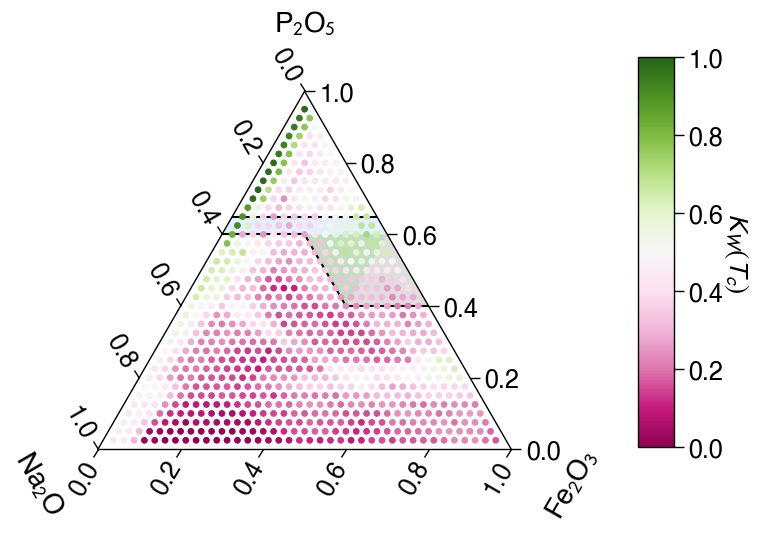

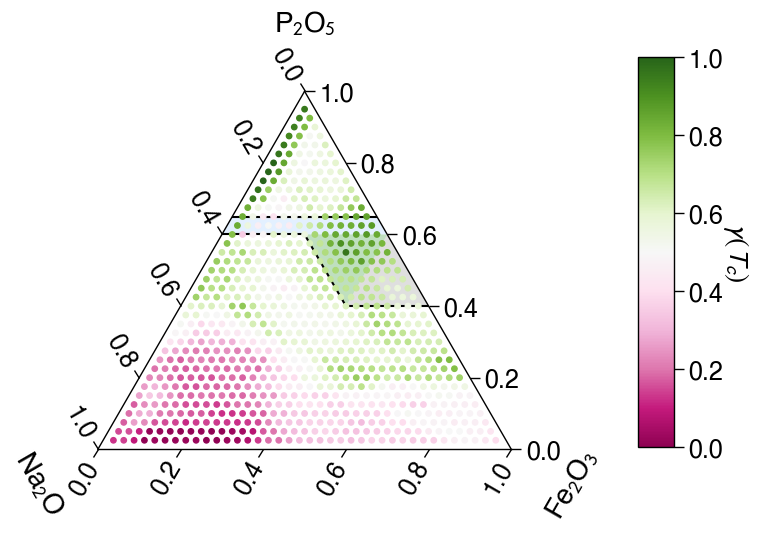

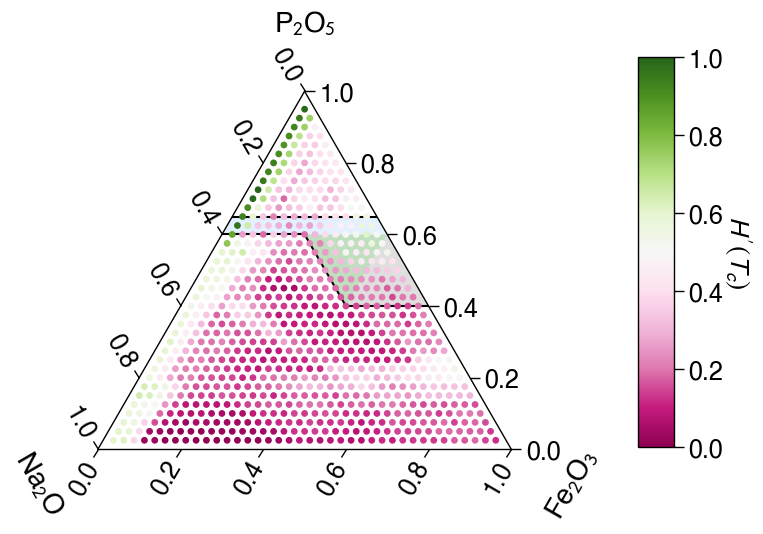

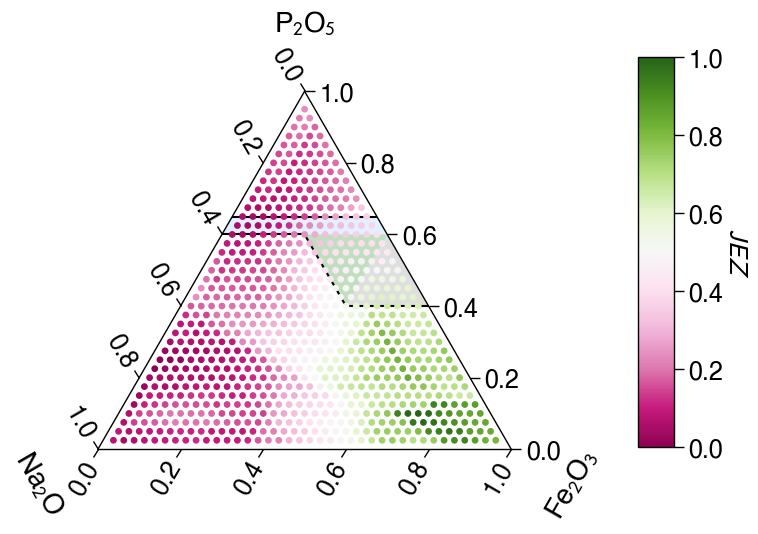

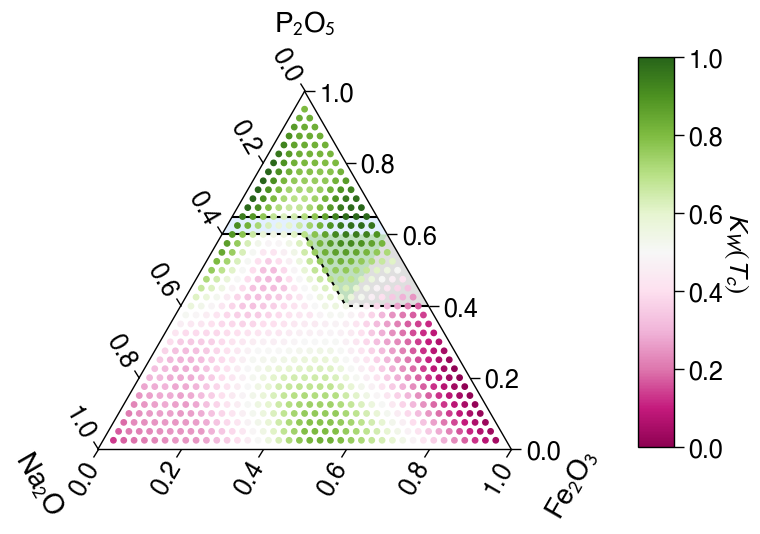

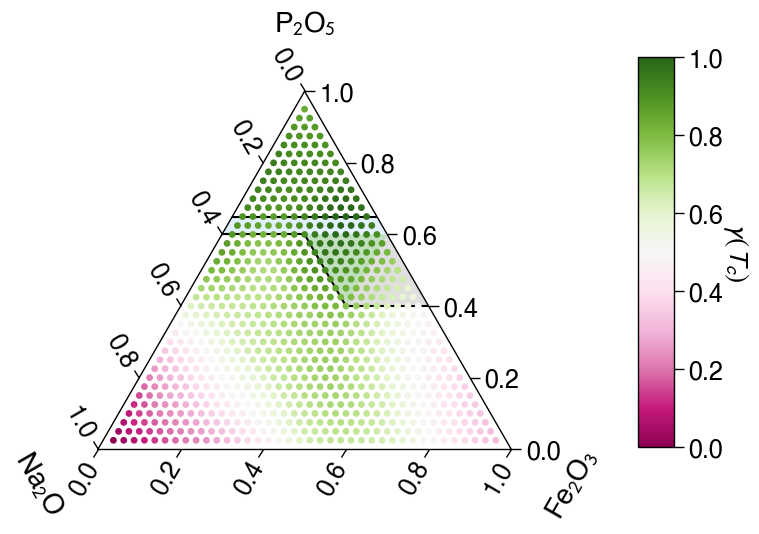

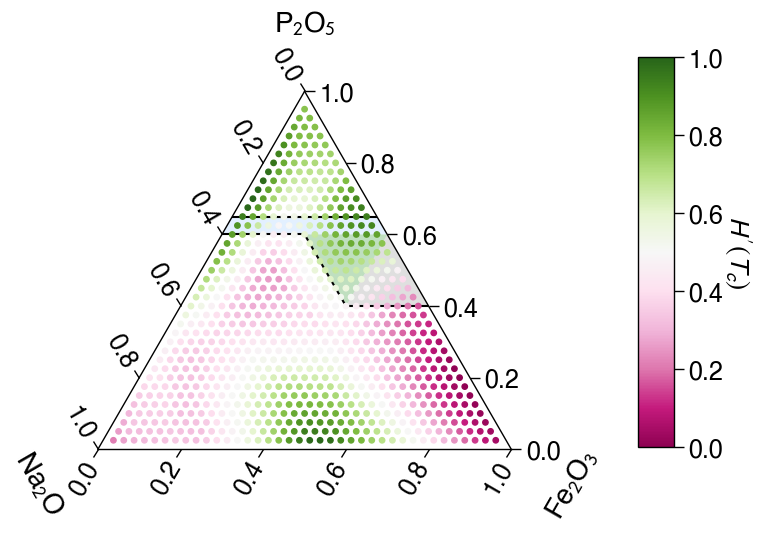

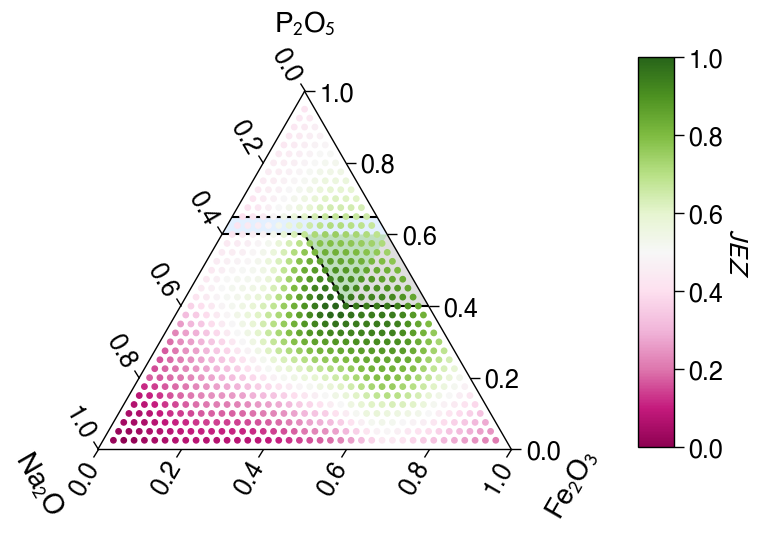

In [28]:
csv_paths = ["GS_NaFePO_rf_direct.csv", "GS_NaFePO_rf_indirect.csv", "GS_NaFePO_glassnet_indirect.csv"]
corner_columns = ["P2O5 at %", "Na2O at %", "Fe2O3 at %"]
columns = ["K_W_Tc", "gamma_Tc", "H_prime_Tc", "Jezica"]
labels = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', r'$H^{\prime}(T_{c})$', r'$JEZ$', 'GS']
for csv_path in csv_paths:
    for i,col in enumerate(columns):
        label = labels[i]
        if col == 'Jezica':
            if csv_path in ["GS_NaFePO_rf_indirect.csv", "GS_NaFePO_glassnet_indirect.csv"]:
                make_ternaries(
                    csv_path=csv_path,
                    column=col,
                    column_label=labels[i],
                    corner_columns=corner_columns,
                    cmap = "PiYG",
                    filename = f"{col}_{csv_path[:-4]}.png"
                )
        else:
            make_ternaries(
                csv_path=csv_path,
                column=col,
                column_label=labels[i],
                corner_columns=corner_columns,
                cmap = "PiYG",
                filename = f"{col}_{csv_path[:-4]}.png"
            )           


$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaBSiO_rf_direct.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaBSiO_rf_direct.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaBSiO_rf_direct.png
$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaBSiO_rf_indirect.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaBSiO_rf_indirect.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaBSiO_rf_indirect.png
$JEZ$
figures/Jezica_GS_NaBSiO_rf_indirect.png
$K_{W}(T_{c})$
figures/K_W_Tc_GS_NaBSiO_glassnet_indirect.png
$\gamma(T_{c})$
figures/gamma_Tc_GS_NaBSiO_glassnet_indirect.png
$H^{\prime}(T_{c})$
figures/H_prime_Tc_GS_NaBSiO_glassnet_indirect.png
$JEZ$
figures/Jezica_GS_NaBSiO_glassnet_indirect.png


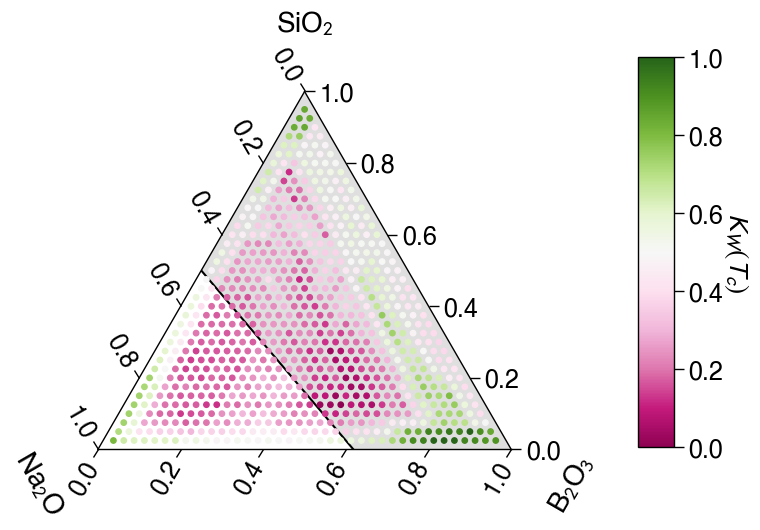

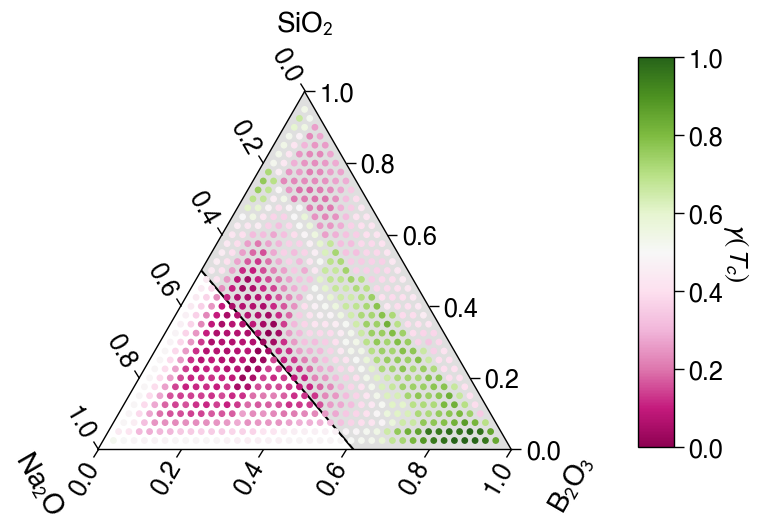

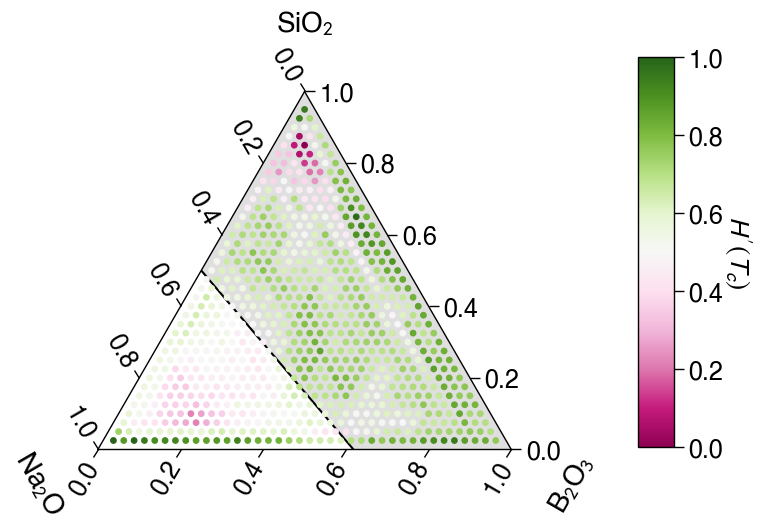

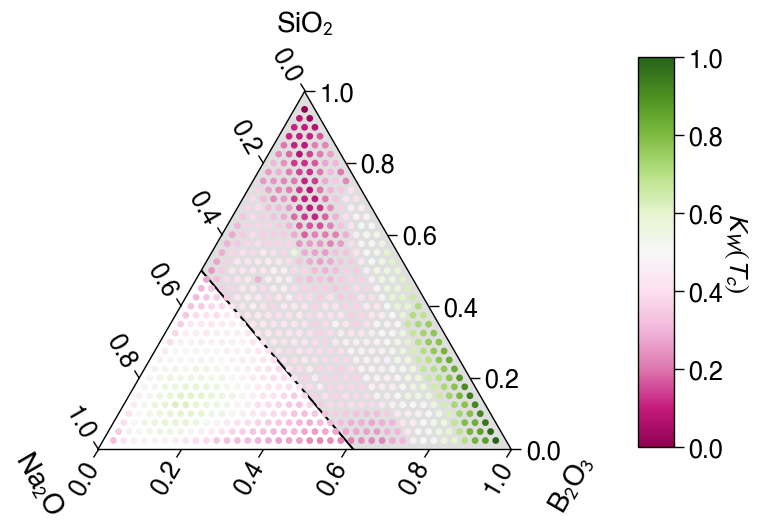

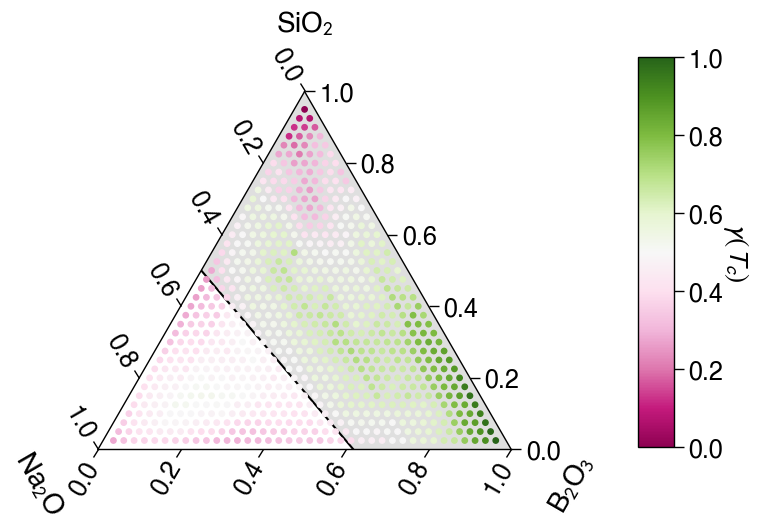

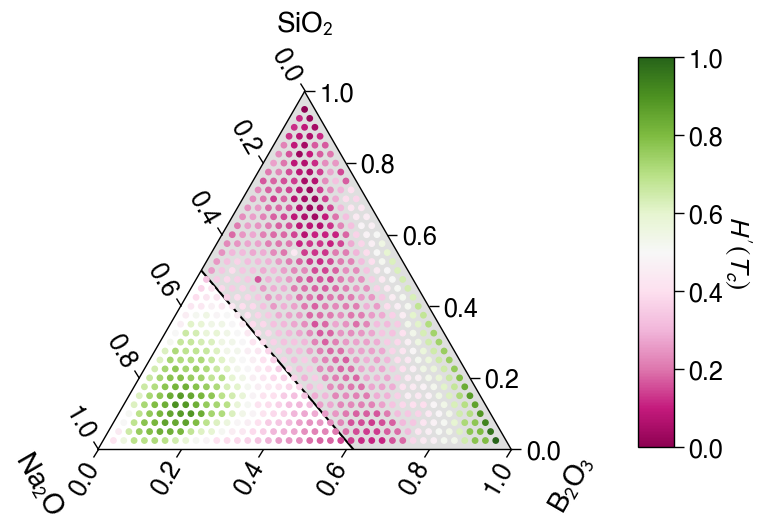

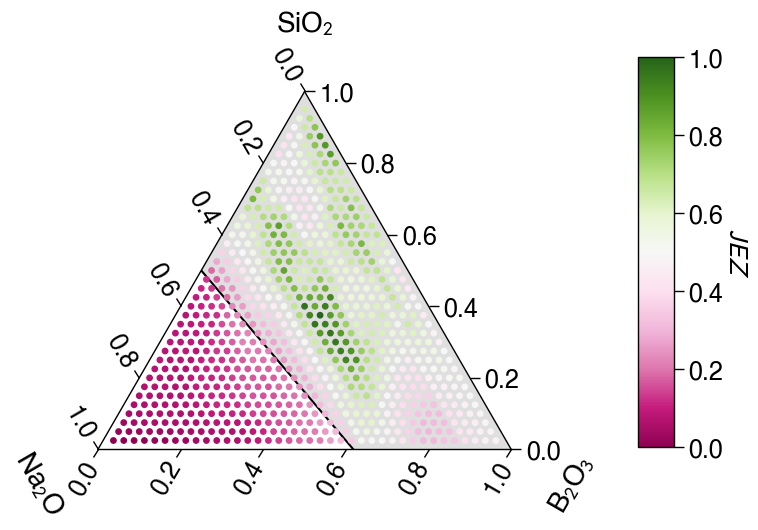

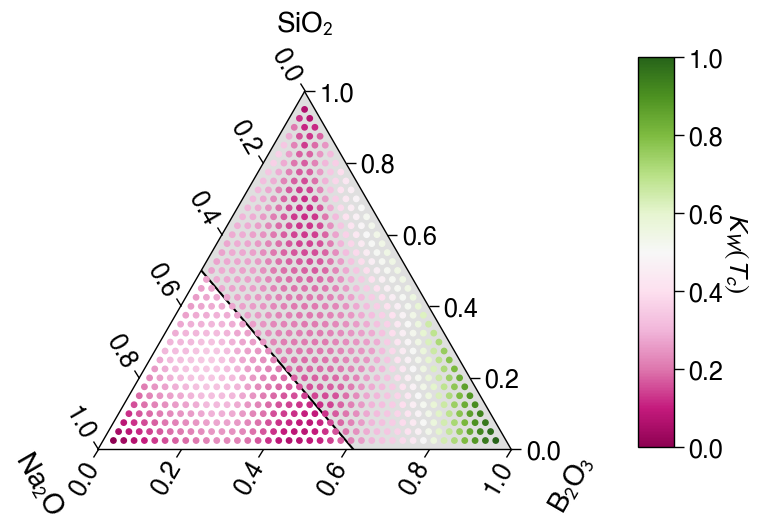

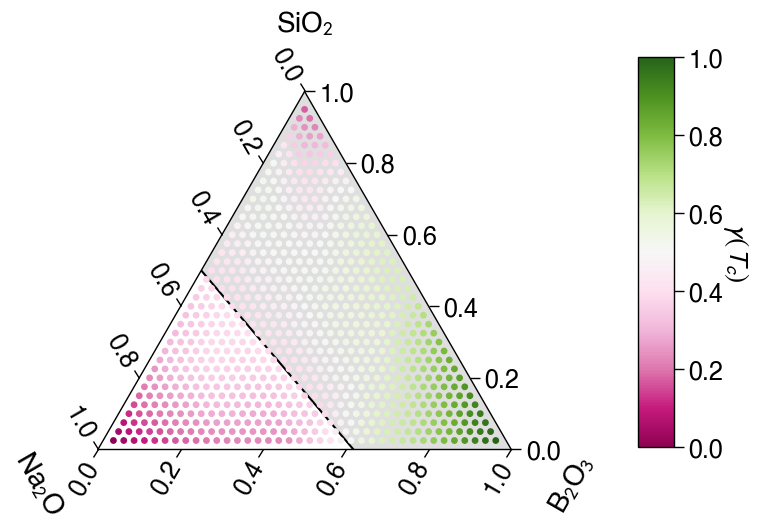

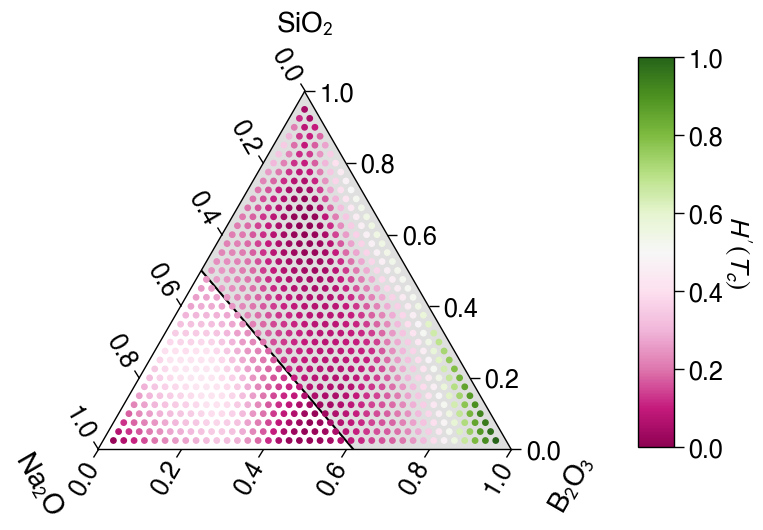

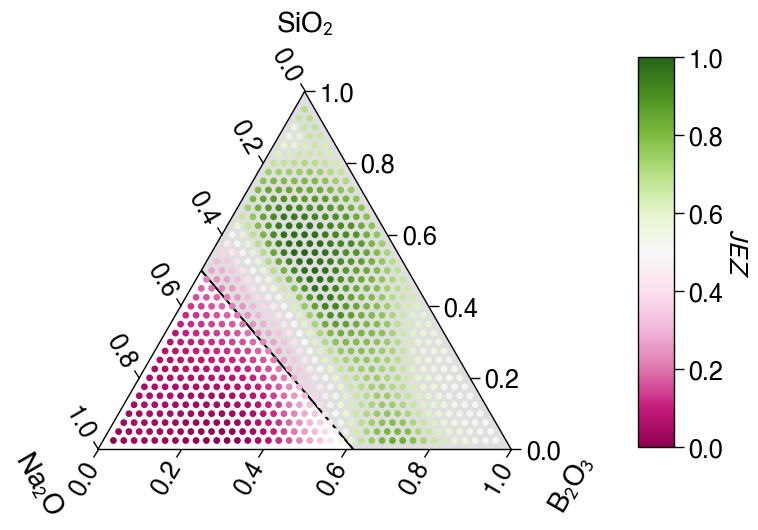

In [29]:

csv_paths = ["GS_NaBSiO_rf_direct.csv", "GS_NaBSiO_rf_indirect.csv", "GS_NaBSiO_glassnet_indirect.csv"]
corner_columns = ["SiO2", "Na2O", "B2O3"]
columns = ["K_W_Tc", "gamma_Tc", "H_prime_Tc", "Jezica"]
labels = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', r'$H^{\prime}(T_{c})$', r'$JEZ$', 'GS']
for csv_path in csv_paths:
    for i,col in enumerate(columns):
        label = labels[i]
        if col == 'Jezica':
            if csv_path in ["GS_NaBSiO_rf_indirect.csv", "GS_NaBSiO_glassnet_indirect.csv"]:
                make_ternaries(
                    csv_path=csv_path,
                    column=col,
                    column_label=labels[i],
                    corner_columns=corner_columns,
                    cmap = "PiYG",
                    filename = f"{col}_{csv_path[:-4]}.png"
                )
        else:
            make_ternaries(
                csv_path=csv_path,
                column=col,
                column_label=labels[i],
                corner_columns=corner_columns,
                cmap = "PiYG",
                filename = f"{col}_{csv_path[:-4]}.png"
            )           


# Composition of sodium iron phosphates and sodium borosilicates in GlassNet data

In [30]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

### NaFePO

In [31]:
elements = X_glassnet_total.columns
elements_not_na_fe_p = [e for e in elements if e != 'Na' and e != 'Fe' and e != 'P']
X_na_fe_p = X_glassnet_total[ (X_glassnet_total['Na'] != 0) & (X_glassnet_total['Fe'] != 0) 
                   & (X_glassnet_total['P'] != 0 ) ]

In [32]:
counts = {}
for i,row in X_na_fe_p.iterrows():
    for e in row[elements_not_na_fe_p][ row[elements_not_na_fe_p] != 0.0 ].index:
        if e not in counts.keys():
            counts[e] = 1
        else:
            counts[e] += 1

In [33]:
others = []
for el, count in counts.items():
    if count > 120:
        others.append( el )

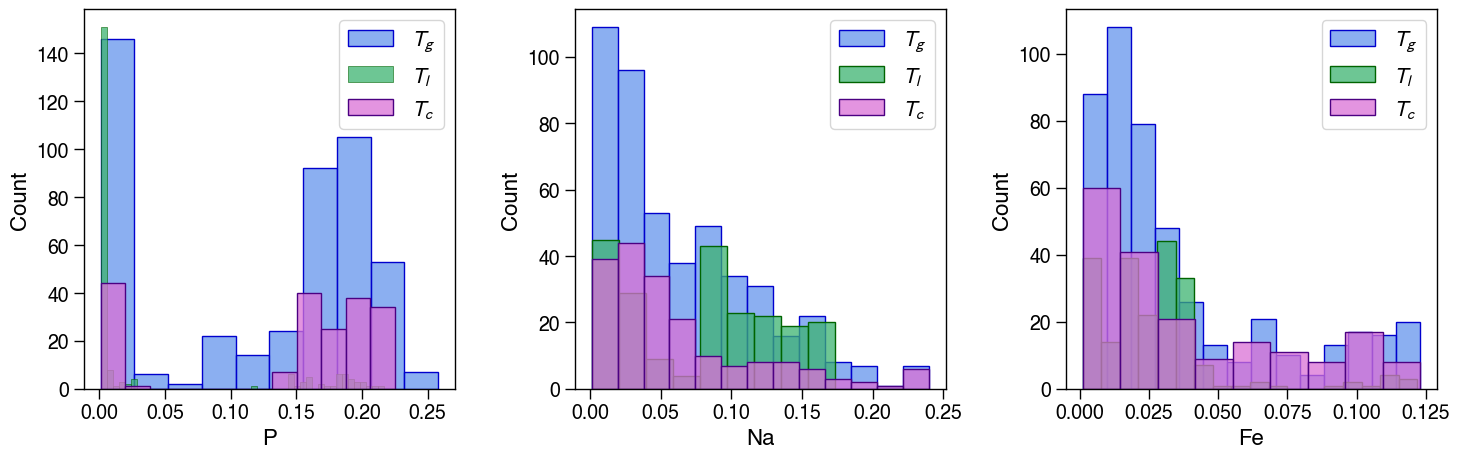

In [34]:
labels = ['$T_g$', '$T_l$', '$T_c$']
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
colors = ['cornflowerblue', 'mediumseagreen', 'orchid']
ecolors = ['mediumblue', 'darkgreen', 'indigo']
for j,el in enumerate( ['P', 'Na', 'Fe'] ):
    ax = axes[j]
    for i,col in enumerate( ['Tg', 'Tliq', 'Tc'] ):
        this_y_glassnet = y_glassnet_total[ col ].dropna()
        this_X_glassnet = X_glassnet_total.loc[ this_y_glassnet.index, : ]
        this_X_na_fe_p = this_X_glassnet[ (this_X_glassnet['Na'] != 0) & (this_X_glassnet['Fe'] != 0) 
                   & (this_X_glassnet['P'] != 0 ) ]
        
        sns.histplot( this_X_na_fe_p [el], ax = ax, color = colors[i], edgecolor = ecolors[i], label = labels[i] )
    ax.legend()
fig.savefig('figure11_1.png', dpi=600)

### NaBSiO

In [35]:
elements = X_glassnet_total.columns
elements_not_na_b_si = [e for e in elements if e != 'Na' and e != 'B' and e != 'Si']
X_na_b_si = X_glassnet_total[ (X_glassnet_total['Na'] != 0) & (X_glassnet_total['B'] != 0) 
                   & (X_glassnet_total['Si'] != 0 ) ]

In [36]:
counts = {}
for i,row in X_na_b_si.iterrows():
    for e in row[elements_not_na_b_si][ row[elements_not_na_b_si] != 0.0 ].index:
        if e not in counts.keys():
            counts[e] = 1
        else:
            counts[e] += 1

In [37]:
others = []
for el, count in counts.items():
    if count > 120:
        others.append( el )

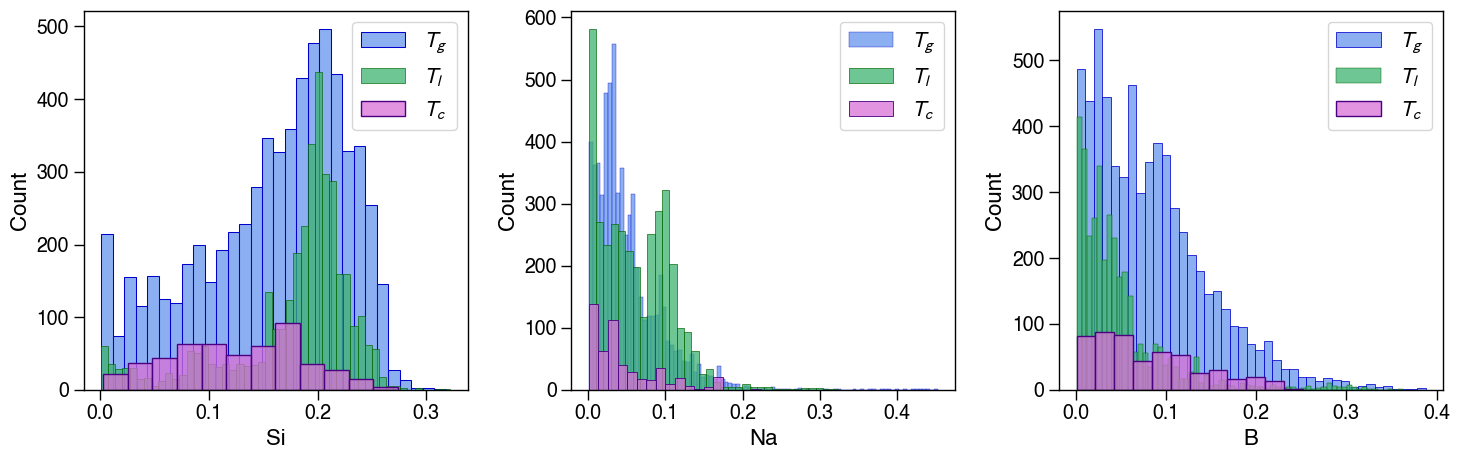

In [38]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
colors = ['cornflowerblue', 'mediumseagreen', 'orchid']
ecolors = ['mediumblue', 'darkgreen', 'indigo']
for j,el in enumerate( ['Si', 'Na', 'B'] ):
    ax = axes[j]
    for i,col in enumerate( ['Tg', 'Tliq', 'Tc'] ):
        this_y_glassnet = y_glassnet_total[ col ].dropna()
        this_X_glassnet = X_glassnet_total.loc[ this_y_glassnet.index, : ]
        this_X_na_b_si = this_X_glassnet[ (this_X_glassnet['Na'] != 0) & (this_X_glassnet['B'] != 0) 
                   & (this_X_glassnet['Si'] != 0 ) ]
        
        sns.histplot( this_X_na_b_si[el], ax = ax, color = colors[i], edgecolor = ecolors[i], label = labels[i] )
    ax.legend()
fig.savefig('figure11_2.png', dpi=600)